### This is from a [tutorial]('https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) from the PyTorch website.

### In this notebook, we will be building and training a basic RNN to classify words. 
### This seems to be a good start for any of you who wish to learn how to implement RNN using PyTorch.
### With RNN, the basics is that we will output a prediction and 'hidden state' at each step, feeding its previous hidden state into each next step.
### For this task, we'll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling.
### We will use some helper code from the tutorial to convert the names from Unicode to ACSII and come up with a dictinoary of lists of names per language.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

home = ' '

print(findFiles(home+'data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(home+'data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['/Users/kimhyunbin/Documents/Python/My own project (Python)/PyTorch_Guide/data/names/Czech.txt', '/Users/kimhyunbin/Documents/Python/My own project (Python)/PyTorch_Guide/data/names/German.txt', '/Users/kimhyunbin/Documents/Python/My own project (Python)/PyTorch_Guide/data/names/Arabic.txt', '/Users/kimhyunbin/Documents/Python/My own project (Python)/PyTorch_Guide/data/names/Japanese.txt', '/Users/kimhyunbin/Documents/Python/My own project (Python)/PyTorch_Guide/data/names/Chinese.txt', '/Users/kimhyunbin/Documents/Python/My own project (Python)/PyTorch_Guide/data/names/Vietnamese.txt', '/Users/kimhyunbin/Documents/Python/My own project (Python)/PyTorch_Guide/data/names/Russian.txt', '/Users/kimhyunbin/Documents/Python/My own project (Python)/PyTorch_Guide/data/names/French.txt', '/Users/kimhyunbin/Documents/Python/My own project (Python)/PyTorch_Guide/data/names/Irish.txt', '/Users/kimhyunbin/Documents/Python/My own project (Python)/PyTorch_Guide/data/names/English.txt', '/Users/kimh

### We have *category_lines*, a dictinoary mapping each category (language) to a list of lines (names).
### *all_categories* is just a list of languages and *n_categories* is the number of languages we have.

In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Turning names into Tensors

### For this task, we would use a one-hot vector of size <1 x n_letters>.
### It would be a sparse matrix overall with binary representations of the presence of the respective letters.
### The eventual joined representation of a word would be a 2D matrix <line_length x 1 x n_letters>

In [7]:
import torch 

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(word):
    tensor = torch.zeros(len(word), 1, n_letters)
    for li, letter in enumerate(word):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### You can understand this as 5 letters in the word 'Jones' and each of the tensor representing individual letters have a single row with 57 columns, each column for every element in the all_letters representation.

# Creating the Network

In [11]:
import torch.nn as nn 

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden),1)
        hidden = self.i2h(combined)
        output = self.softmax(self.i2o(combined))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

### This network will be ran as such.
### We will pass an input (the Tensor for the current letter) and a previous hidden state (which is initilized as zeroes first).
### We will get back the output (probability of each langugage) and a next hidden state (for the next time step).

In [16]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)
output.size(), next_hidden.size()

(torch.Size([1, 18]), torch.Size([1, 128]))

### In practice, we would convert the whole letter to Tensors which our model would be able to interpret.

In [17]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
output

tensor([[-2.9647, -2.8111, -2.7743, -2.9133, -2.8510, -3.0001, -2.8762, -2.7799,
         -2.9853, -2.9864, -2.8899, -2.9542, -2.9563, -2.8634, -2.9135, -2.9159,
         -2.7841, -2.8538]], grad_fn=<LogSoftmaxBackward0>)

### The output is a tensor showing the probability for each criteria. 
### The higher the numerical figure, the more likely it is that the name is from that specific language.

# Training

## Preparing for training

### Let's create a helper function to be able to interpret the output of the network.

In [18]:
def categoryFromOutput(input):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Arabic', 2)


### Let's also make a way to get a training example quickly. (The name and it's language)

In [19]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = German / line = Achterberg
category = Irish / line = Brian
category = Arabic / line = Asker
category = Irish / line = Braden
category = Arabic / line = Sarraf
category = Portuguese / line = Fonseca
category = Japanese / line = Inihara
category = Arabic / line = Basara
category = Vietnamese / line = Trang
category = Vietnamese / line = Trang


## Training the Network

In [21]:
# Loss function
criterion = nn.NLLLoss()

lr = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward() # Backpropagation of loss

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -lr) # Optimizing

    return output, loss.item()

### Now, we just need to run this through a bunch of examples.

In [22]:
import time
import math 

n_iters = 100000
print_every = 5000
plot_every = 1000


current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now-since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 1s) 2.8030 Naggia / Portuguese ✗ (Italian)
10000 10% (0m 3s) 1.3517 Grzeskiewicz / Greek ✗ (Polish)
15000 15% (0m 5s) 1.2700 Dam / Chinese ✗ (Vietnamese)
20000 20% (0m 7s) 2.4974 Cunningham / Irish ✗ (Scottish)
25000 25% (0m 8s) 2.9721 Yasui / Arabic ✗ (Japanese)
30000 30% (0m 10s) 1.1852 Ri / Korean ✓
35000 35% (0m 12s) 1.9341 Fabbro / Portuguese ✗ (Italian)
40000 40% (0m 14s) 0.8140 Cuidightheach / Irish ✓
45000 45% (0m 15s) 4.2821 Vainberg / Scottish ✗ (Russian)
50000 50% (0m 17s) 1.7392 Hoch / German ✓
55000 55% (0m 19s) 3.8408 Jagoda / Japanese ✗ (Polish)
60000 60% (0m 21s) 0.0385 Stamatelos / Greek ✓
65000 65% (0m 23s) 4.8141 Gall / Irish ✗ (Russian)
70000 70% (0m 24s) 2.3295 Brown / Dutch ✗ (Scottish)
75000 75% (0m 26s) 1.0044 Hohki / Polish ✗ (Japanese)
80000 80% (0m 28s) 1.2199 Chu / Korean ✗ (Vietnamese)
85000 85% (0m 30s) 0.0763 Rodrigues / Portuguese ✓
90000 90% (0m 32s) 1.3167 Leclerc / French ✓
95000 95% (0m 33s) 0.1709 Hadad / Arabic ✓
100000 100% (0m 35s) 2.

## Plotting the results

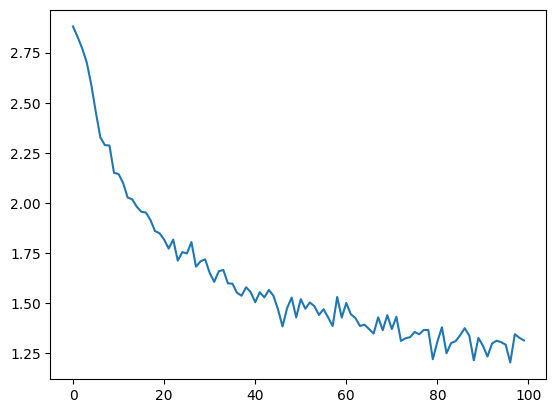

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluating the Results

### For evaluation, we will plot a confusion matrix.

/var/folders/g6/g9hyk9sx7nsbmqrzpj5z10fc0000gn/T/ipykernel_4747/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/g6/g9hyk9sx7nsbmqrzpj5z10fc0000gn/T/ipykernel_4747/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


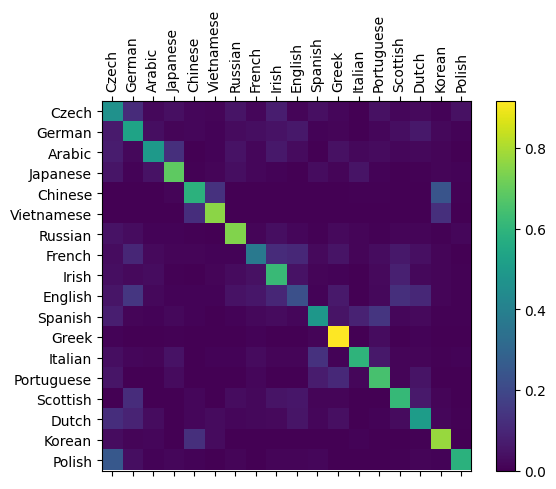

In [24]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### The brighter the color, the more correctly it has predicted.

### This was a very basic introduction to RNN using PyTorch.